# Timo's notes on building an RNN for classification with PyTorch 
Our first target is the classification of (German) verbs vs. adjectives. The classifier that we build on this basis will, however, be able to learn to classify any type of character sequence.

- Potentially, we could simply use the last 3 characters of the word and feed these features into a (very normal! feed-forward) neural network. It would have ~26*3 input neurons (unless we have more different characters, which might very well be the case) and number_of_classes output neurons (for two classes we could get by with just one neuron). There will also be a hidden/inner layer with some dimensionality.
- the approach sketched above does not scale to longer sequences (where the interesting parts might not be the last three characters). In particular, sequences have different lengths, they might also be shorter than 3 characters!
- we differentiate between two parts of the classifier: we first _encode_ the sequence and we then classify based on this encoding.

In [24]:
import torch
import torch.nn as nn
import ipywidgets as widgets
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [25]:
%%capture
# now, the following is cool: it lets us import functions that we have defined in other notebooks! 
%run PyTorch.ipynb import plot

In [26]:
# code for loading two lists of training items from separate files.
# let's use the following data layout:
# - we have a central list (data, or training, or test, or the like) which contains
# - pairs of (class-assignment, data-to-be-classified).
# - (we could also have a list "apply" in which case we would not have any class-assignments, obviously)
# - we'll have a list "CLASS_NAMES" and therefore the class-assignment will be a number (index into the class_names list)
# - data-to-be-classified is again a list (sequence data, right?)
# - our sequence data is characters. pooler_output
CLASS_NAMES = []

def load_class_from_file(filename, class_name=None) -> list:
    if class_name is None:
        class_name = filename
    if not class_name in CLASS_NAMES:
        CLASS_NAMES.append(class_name)
    class_index = CLASS_NAMES.index(class_name)
    with open(filename, 'r') as f:
        data = [[class_index, l.strip()] for l in f.readlines()]
    return data
data = load_class_from_file('data/adjektive.words', 'adjektive')
data.extend(load_class_from_file('data/verben.words', 'verben'))
random.shuffle(data)
print(list(enumerate(CLASS_NAMES)))
NUM_CLASSES = len(CLASS_NAMES)
print(data[0:4])
# this prints the names of the classes and some examples of each

[(0, 'adjektive'), (1, 'verben')]
[[0, 'vorigen'], [1, 'erhielt'], [0, 'hohem'], [0, 'effektive']]


In [27]:
# the data cannot yet be put to use,
# we still need to convert the input into numbers that can be used as input into the network.
CHARACTERS = set()
for d in data:
    CHARACTERS = CHARACTERS.union(d[1])
NUM_CHARACTERS = len(CHARACTERS)
int_to_char = sorted(CHARACTERS)
char_to_int = {c:i for i,c in enumerate(CHARACTERS)}
for d in data:
    d.append([char_to_int[c] for c in d[1]])
print(int_to_char)
print(data[0:4])
# this prints the characters that we find in our data, 
# as well as the indices that we have now added to each entry of our data

['-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ä', 'ß', 'ä', 'ö', 'ü']
[[0, 'vorigen', [12, 3, 16, 37, 2, 38, 22]], [1, 'erhielt', [38, 16, 29, 37, 38, 20, 11]], [0, 'hohem', [29, 3, 29, 38, 28]], [0, 'effektive', [38, 14, 14, 38, 51, 11, 37, 12, 38]]]


In [28]:
# let's implement a classifier that is based on the last 3 characters only.
# NOTE: This is not a recurrent neural network, only a "regular" neural network.
# it takes as input the last CONTEXT_SIZE characters and learns to find patterns 
# in these characters to differentiate verbs and adjectives

# input into the network will be represented as "one hot" for each of the context characters.
# for each context character, we have one neuron for each of the different letters (see above)
# in total, there will be something like 63*3 neurons. 3 of them will be set to 1, the others to 0.

CONTEXT_SIZE = 3
class SimpleNGramClassifier(nn.Module):
    def __init__(self):
        super(SimpleNGramClassifier, self).__init__()
        self.input_size = CONTEXT_SIZE * NUM_CHARACTERS 
        self.A = nn.Parameter(nn.init.xavier_uniform_(torch.empty(self.input_size, NUM_CLASSES)))
        self.b = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, NUM_CLASSES)))

    def forward(self, xs : list):
        input = torch.zeros(1, self.input_size)
        for i,x in enumerate(xs[len(xs)-CONTEXT_SIZE:]): # focus only on the last CONTEXT_SIZE characters
            input[0, i * NUM_CHARACTERS + x] = 1.
        return nn.functional.softmax(input @ self.A  + self.b, dim=1)

## Model
Above, we have already implemented a classifier (the trivial one that looks at the last few characters and attempts to find patterns in them). Later, we will implement a few more complex ones.

The classifier is a *model* that uses some assumptions (e.g., ignore everything but the prefix) to get us from some input to some output (in the case of classification: which of the classes the data instance belongs to). Machine learning models use some parameters to generate their output.

What are the parameters above, where are they used to compute the output and where are they set up?
<details>
    The model above uses the parameters <code>self.A</code> and <code>self.B</code> which are defined in the constructor and are used in the forward function where they are multiplied and added to the input vector and then fed to the softmax function for classification: <code>nn.functional.softmax(input @ self.A + self.b, dim=1)</code>
</details>

## Training
Machine learning models need to be *trained*. This process involves changing the parameters of the model so that it yields the best possible results. This short answer leaves open two questions: what is the measure that we use to make the "best possible" quantifiable, and on what data do we measure. 

Machine learning uses so called *training data* (see above and below) to optimize the parameters. We measure the quality of the current parameterization in terms of the error of the desired outcome in some way that is easily measurable and differentiable. Why differentiable? Because we want to compute the gradient and use gradient descent to optimize the parameters. (Notice that "correctness" of the classifier is not differentiable, because it's either true or not and there's no gray area; we use something slightly more complex below.)

A typical approach is to pass over the training data multiple times (each of these is called an *epoch*), to compute the results of the model as it is now for one or multiple items in the training data, and to then change the model. We often compute the performance of the model after every epoch on some held-out test (or validation) data.

Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting
Epoch 10 starting


SimpleNGramClassifier()

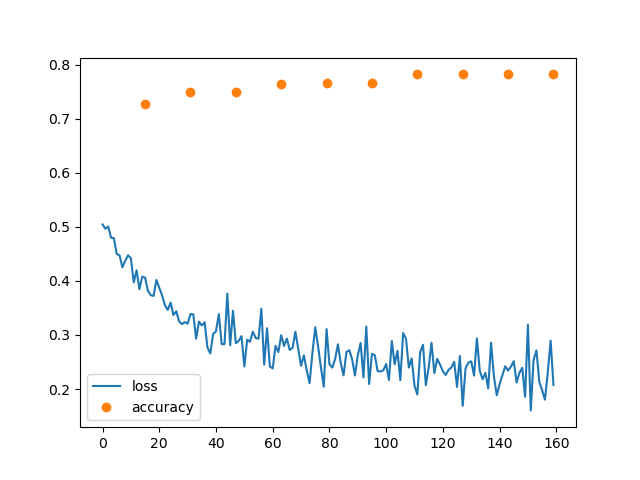

In [29]:
def training(Classifier=SimpleNGramClassifier):
    train, test = torch.utils.data.random_split(data, [0.8, 0.2])
    #print(list(train)[0:4])
    classify = Classifier()
    plot_data = defaultdict(lambda : [])
    optimizer = torch.optim.Adam(classify.parameters())
    plot_every = 100
    training_counter = 1
    
    for epoch in range(10):
        print(("Epoch {} starting".format(epoch+1)))
        random.shuffle(train.indices)
        aggr_loss = 0
        for cls, word, ints in train:
            optimizer.zero_grad()
            output = classify(ints)
            loss  = nn.functional.nll_loss(output, torch.tensor([cls]))
            loss.backward()
            aggr_loss += 1 + loss.item()
            optimizer.step()
            if training_counter % plot_every == 0:
                plot_data["loss"].append(aggr_loss / plot_every)
                aggr_loss = 0
            training_counter += 1
        
        # test performance of classifier:
        plot_data["accuracy"].extend([None] * int(len(train) / plot_every - 1))
        correct = 0
        for cls, _, ints in test:
            output = classify(ints)
            prediction = int(torch.topk(output, 1)[1].item())
            correct += 1 if prediction == cls else 0
        plot_data["accuracy"].append(correct / len(test))

    plot(plot_data)
    return classify

%matplotlib widget
training()

The classifier above is not all that bad, considering that it only looks at the last 3 letters. It's correct 80% of the time after some while. (It gets to 70% if looking at the last 2 letters, it doesn't get much better with 4 or more letters -- but try for yourself!)

Below, we'll instead try to look at the complete letter sequence (no matter how long it is) and let the model decide how many letters it really needs to look at. For that, we employ an RNN to which we feed each of the letters (or rather: their one-hot encodings, as above) to the network, and condense the letter sequence to a fixed-sized vector (of size 64, or `HIDDEN_SIZE` below). 

Once the input is encoded to a fixed size (which is done in `RNN_Layer` below, we can use it in a regular feed-forward classification layer (the `nn.Linear` layer `RNNClassifier.final_layer` below; we previously implemented our own linear layer when we had our matrix `A` and vector `b` in `SimpleNGramClassifier` above). `RNNClassifier` binds the two elements -- encoder of the sequence and classifier of the encoding -- together.

Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting
Epoch 10 starting


RNNClassifier(
  (rnn): RNN_Layer()
  (final_layer): Linear(in_features=64, out_features=2, bias=True)
)

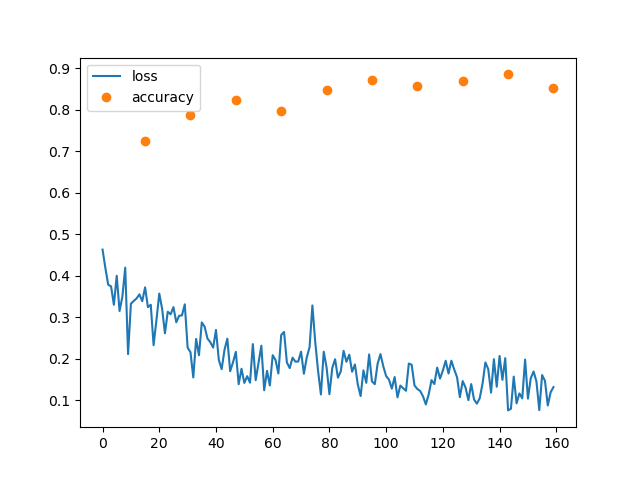

In [30]:
INPUT_SIZE = NUM_CHARACTERS
HIDDEN_SIZE = 64
# okay, what's a recurrent neural network anyway? see https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recurrent-neural-network/recurrent_neural_networks
# At every time step, we have an input, 
class RNN_Layer(nn.Module):
    def __init__(self):
        super(RNN_Layer, self).__init__()
        self.Wx = nn.Parameter(nn.init.xavier_uniform_(torch.empty(INPUT_SIZE, HIDDEN_SIZE)))
        self.Wh = nn.Parameter(nn.init.xavier_uniform_(torch.empty(HIDDEN_SIZE, HIDDEN_SIZE)))
        self.b = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, HIDDEN_SIZE)))
#        self.Wx = nn.Linear(INPUT_SIZE, HIDDEN_SIZE, bias=false)
#        self.Wh = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=true)

    def step(self, x: torch.Tensor, state : torch.Tensor) -> torch.Tensor:
        return nn.functional.tanh(x @ self.Wx + state @ self.Wh + self.b)
        # or: return nn.functional.tanh(self.Wx(x) + self.Wh(x))
    
    def forward(self, xs : list) -> torch.Tensor:
        xs = [torch.nn.functional.one_hot(torch.tensor(x), num_classes=INPUT_SIZE).float() for x in xs]
        state = torch.zeros(1, HIDDEN_SIZE)
        for x in xs:
            state = self.step(x, state)
        return state

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.rnn = RNN_Layer()
        self.final_layer = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, xs : list):
        sequence_encoding = self.rnn(xs)
        result = nn.functional.softmax(self.final_layer(sequence_encoding), dim=1)
        return result

%matplotlib widget
training(RNNClassifier)

Wow, this classifier works much better, getting upto 90% right instead of 80% as before (i.e., cutting the error rate in half from 20% to 10%). As you can see above, we implemented a lot of things ourselves. Luckily, torch has pre-defined modules for many things, including various recurrent layers (such as RNN, LSTM or GRU). See below the consolidated implementation which works quite identically to the one above (where we implemented more ourselves).

Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting
Epoch 10 starting


PyTorchRNNClassifier(
  (rnn): RNN(63, 64)
  (final_layer): Linear(in_features=64, out_features=2, bias=True)
)

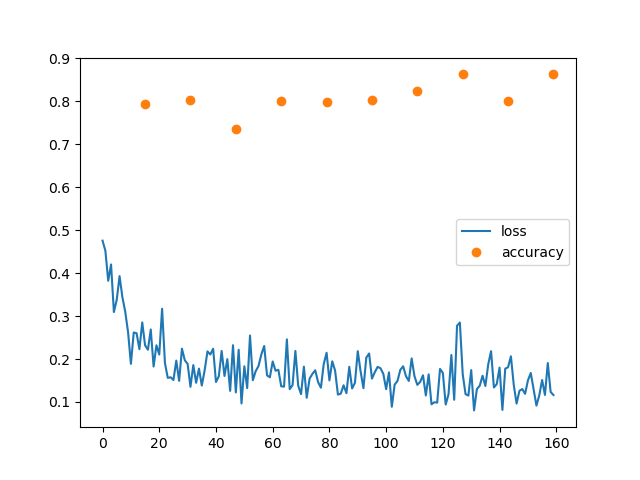

In [32]:
HIDDEN_SIZE = 64
class PyTorchRNNClassifier(nn.Module):
    def __init__(self):
        super(PyTorchRNNClassifier, self).__init__()
        self.rnn = nn.RNN(INPUT_SIZE, HIDDEN_SIZE, 1) # RNN or LSTM or GRU
        self.final_layer = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, xs : list):
        xs = torch.nn.functional.one_hot(torch.tensor(xs), num_classes=INPUT_SIZE).float()
        rnn_output, hidden_states = self.rnn(xs)
        final_output = rnn_output[-1].reshape(1,HIDDEN_SIZE)
        return nn.functional.softmax(self.final_layer(final_output), dim=1)

%matplotlib widget
training(PyTorchRNNClassifier)

Often, it is not desirable to use one-hot encodings as inputs. Specifically, if we were using words as inputs instead of letters, we'd need some 100000s to capture the most relevant words. (People nowadays talk about *tokens* and typically use some 100000s of different tokens that their models can use. 

A major problem with one-hot encodings is the fact that matrices get very large, making computations slow. However, additionally, they also make it impossible to capture *similarity* of tokens. (Such as lower/uppercase characters being similar to each other). We can either pre-train word embeddings (which was done in the 2000s: word2vec, ...), or we can optimize them as part of our model. Basically, we represent each of the tokens of our input (in our case characters, but similarly for words or other partitions of our sequences) by a vector of some size, say `INPUT_SIZE`). We use that as before as you can see below:

Epoch 0 starting
Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting


EmbeddingsAndRNNClassifier(
  (embed): Embeddings(
    (W): Linear(in_features=63, out_features=32, bias=False)
  )
  (rnn): GRU(32, 64)
  (final_layer): Linear(in_features=64, out_features=2, bias=True)
)

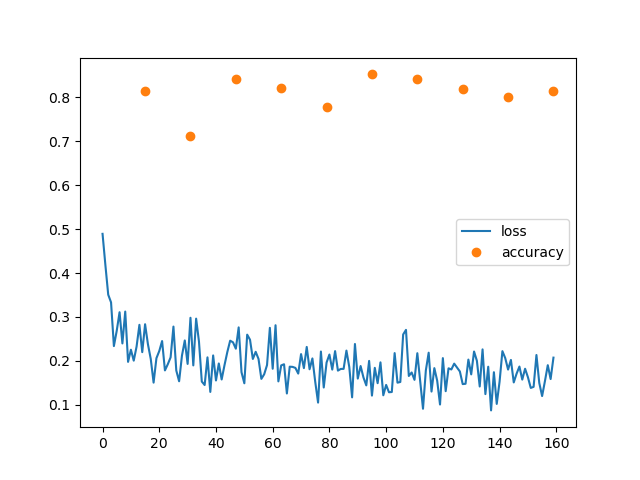

In [10]:
INPUT_SIZE = 32

class Embeddings(nn.Module):
    def __init__(self):
        super(Embeddings, self).__init__()
        self.W = nn.Linear(NUM_CHARACTERS, INPUT_SIZE, bias=False)

    def forward(self, xs : list):
        xs = self.W(torch.nn.functional.one_hot(torch.tensor(xs), num_classes=NUM_CHARACTERS).float())
        return xs

class EmbeddingsAndRNNClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingsAndRNNClassifier, self).__init__()
        self.embed = Embeddings()
        self.rnn = nn.GRU(INPUT_SIZE, HIDDEN_SIZE, 1)
        self.final_layer = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, xs : list):
        xs = self.embed(xs)
        rnn_output, hidden_states = self.rnn(xs)
        final_output = rnn_output[-1].reshape(1,HIDDEN_SIZE)
        return nn.functional.softmax(self.final_layer(final_output), dim=1)

%matplotlib widget
training(EmbeddingsAndRNNClassifier)

(Of course, we could have used `torch.nn.Embedding` above, but that would have been boring.)

In the case above, there's hardly an influence of the embedding layer. However, the same classifiers as above can be used for more complex data (e.g., classifying restaurant reviews as positive or negative) and it will likely help there.